In [1]:
import pandas as pd
import numpy as np
import re
import string
import json
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from collections import Counter
from wordcloud import WordCloud

In [2]:
df = pd.read_csv('/kaggle/input/e-commerce-customer-behavior-dataset/E-commerce.csv')

In [3]:
df.head()

,Customer ID,Age,Gender,Location,Annual Income,Purchase History,Browsing History,Product Reviews,Time on Site
0,1001,25,Female,City D,45000,"[{""Date"": ""2022-03-05"", ""Category"": ""Clothing""...","[{""Timestamp"": ""2022-03-10T14:30:00Z""}, {""Time...","Great pair of jeans, very comfortable. Rating:...",32.50
1,1001,28,Female,City D,52000,"[{""Product Category"": ""Clothing"", ""Purchase Da...","[{""Product Category"": ""Home & Garden"", ""Timest...",Great customer service!,123.45
2,1001,28,Female,City D,65000,"[{""Product Category"": ""Electronics"", ""Purchase...","[{""Product Category"": ""Clothing"", ""Timestamp"":...",Great electronics. The sound quality is excell...,125.60
3,1001,45,Female,City D,70000,"{'Purchase Date': '2022-08-15', 'Product Categ...",{'Timestamp': '2022-09-03 14:30:00'},"{""Product 1"": {""Rating"": 4, ""Review"": ""Great e...",327.60
4,1002,34,Male,City E,45000,"{'Purchase Date': '2022-07-25', 'Product Categ...",{'Timestamp': '2022-08-10 17:15:00'},"{""Product 1"": {""Rating"": 3, ""Review"": ""Good pr...",214.90


In [4]:
df.shape

(50, 9)

In [5]:
df.isnull().sum()

Customer ID         0
Age                 0
Gender              0
Location            0
Annual Income       0
Purchase History    0
Browsing History    0
Product Reviews     0
Time on Site        0
dtype: int64

In [6]:
# text cleaning

def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'product\s+rating\s+review', '', text, flags=re.IGNORECASE)
    text = re.sub(r'review\s+text', '', text, flags=re.IGNORECASE)
    text = text.lower()
    text = text.strip()
    return text

df['Cleaned_Reviews'] = df['Product Reviews'].apply(clean_text)

In [7]:
df.head()

,Customer ID,Age,Gender,Location,Annual Income,Purchase History,Browsing History,Product Reviews,Time on Site,Cleaned_Reviews
0,1001,25,Female,City D,45000,"[{""Date"": ""2022-03-05"", ""Category"": ""Clothing""...","[{""Timestamp"": ""2022-03-10T14:30:00Z""}, {""Time...","Great pair of jeans, very comfortable. Rating:...",32.50,great pair of jeans very comfortable rating s...
1,1001,28,Female,City D,52000,"[{""Product Category"": ""Clothing"", ""Purchase Da...","[{""Product Category"": ""Home & Garden"", ""Timest...",Great customer service!,123.45,great customer service
2,1001,28,Female,City D,65000,"[{""Product Category"": ""Electronics"", ""Purchase...","[{""Product Category"": ""Clothing"", ""Timestamp"":...",Great electronics. The sound quality is excell...,125.60,great electronics the sound quality is excelle...
3,1001,45,Female,City D,70000,"{'Purchase Date': '2022-08-15', 'Product Categ...",{'Timestamp': '2022-09-03 14:30:00'},"{""Product 1"": {""Rating"": 4, ""Review"": ""Great e...",327.60,great experience buying this product fast deli...
4,1002,34,Male,City E,45000,"{'Purchase Date': '2022-07-25', 'Product Categ...",{'Timestamp': '2022-08-10 17:15:00'},"{""Product 1"": {""Rating"": 3, ""Review"": ""Good pr...",214.90,good product but could have been better


In [8]:
def get_sentiment_textblob(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'Positive'
    elif polarity < 0:
        return 'Negative'
    else:
        return 'Neutral'
    
df['Sentiment_Textblob'] = df['Cleaned_Reviews'].apply(get_sentiment_textblob)

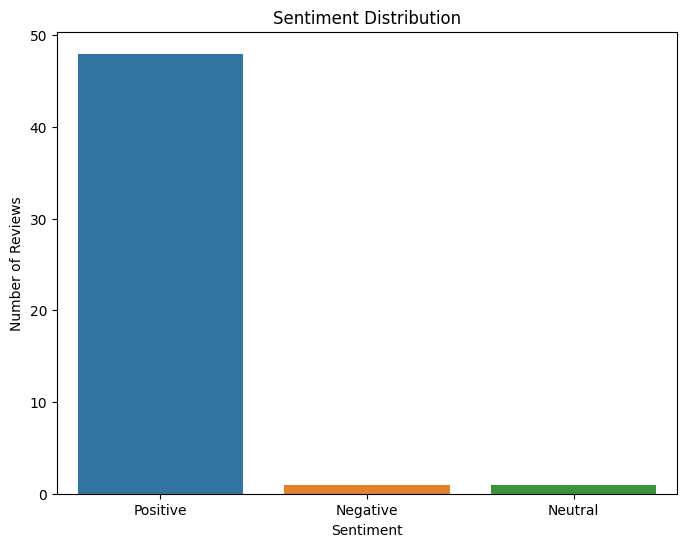

In [9]:
plt.figure(figsize=(8,6))
sns.countplot(x='Sentiment_Textblob', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [10]:
sentiment_pipeline = pipeline('sentiment-analysis')

def get_sentiment_transformers(text):
    result = sentiment_pipeline(text[:512])
    return result[0]['label']

df['Sentiment_BERT'] = df['Cleaned_Reviews'].apply(get_sentiment_transformers)

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


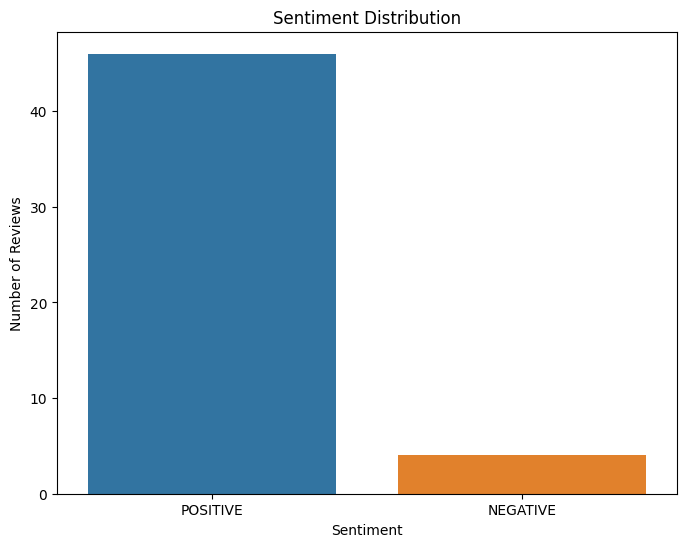

In [11]:
plt.figure(figsize=(8,6))
sns.countplot(x='Sentiment_BERT', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()

In [12]:
# customer segmentation

le_gender = LabelEncoder()
le_location = LabelEncoder()

In [13]:
df['Gender'] = le_gender.fit_transform(df['Gender'])
df['Location'] = le_location.fit_transform(df['Location'])

In [14]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[['Age', 'Annual Income', 'Time on Site', 'Gender', 'Location']])

In [15]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df_scaled)
df['Cluster'] = kmeans.labels_

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
df["Cluster"] = df["Cluster"].replace(0, "Value-Conscious, Low Engagement")
df["Cluster"] = df["Cluster"].replace(1, "High-Income, High Engagement Shoppers")

In [17]:
df.rename(columns={"Cluster": "Customer Type"}, inplace= True)

In [18]:
df.head()

,Customer ID,Age,Gender,Location,Annual Income,Purchase History,Browsing History,Product Reviews,Time on Site,Cleaned_Reviews,Sentiment_Textblob,Sentiment_BERT,Customer Type
0,1001,25,0,3,45000,"[{""Date"": ""2022-03-05"", ""Category"": ""Clothing""...","[{""Timestamp"": ""2022-03-10T14:30:00Z""}, {""Time...","Great pair of jeans, very comfortable. Rating:...",32.50,great pair of jeans very comfortable rating s...,Positive,POSITIVE,"Value-Conscious, Low Engagement"
1,1001,28,0,3,52000,"[{""Product Category"": ""Clothing"", ""Purchase Da...","[{""Product Category"": ""Home & Garden"", ""Timest...",Great customer service!,123.45,great customer service,Positive,POSITIVE,"Value-Conscious, Low Engagement"
2,1001,28,0,3,65000,"[{""Product Category"": ""Electronics"", ""Purchase...","[{""Product Category"": ""Clothing"", ""Timestamp"":...",Great electronics. The sound quality is excell...,125.60,great electronics the sound quality is excelle...,Positive,POSITIVE,"Value-Conscious, Low Engagement"
3,1001,45,0,3,70000,"{'Purchase Date': '2022-08-15', 'Product Categ...",{'Timestamp': '2022-09-03 14:30:00'},"{""Product 1"": {""Rating"": 4, ""Review"": ""Great e...",327.60,great experience buying this product fast deli...,Positive,POSITIVE,"High-Income, High Engagement Shoppers"
4,1002,34,1,4,45000,"{'Purchase Date': '2022-07-25', 'Product Categ...",{'Timestamp': '2022-08-10 17:15:00'},"{""Product 1"": {""Rating"": 3, ""Review"": ""Good pr...",214.90,good product but could have been better,Positive,POSITIVE,"Value-Conscious, Low Engagement"


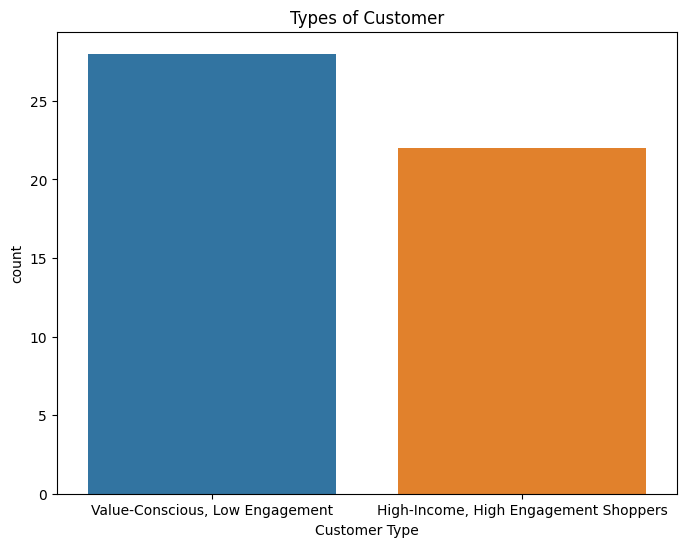

In [19]:
plt.figure(figsize=(8,6))
sns.countplot(x='Customer Type', data=df)
plt.title('Types of Customer')
plt.show()

In [20]:
# purchase behaviour analysis

def correct_json_format(purchase_history):
    corrected = purchase_history.replace("'", '"')
    corrected = corrected.replace('},]', '}],') 
    try:
        return json.loads(f"[{corrected}]") 
    except json.JSONDecodeError:
        return []

In [21]:
df['Corrected Purchase History'] = df['Purchase History'].apply(correct_json_format)

In [22]:
def count_purchases(purchase_history):
    return len(purchase_history)

In [23]:
df['Num Purchases'] = df['Corrected Purchase History'].apply(count_purchases)

In [24]:
df.head()

,Customer ID,Age,Gender,Location,Annual Income,Purchase History,Browsing History,Product Reviews,Time on Site,Cleaned_Reviews,Sentiment_Textblob,Sentiment_BERT,Customer Type,Corrected Purchase History,Num Purchases
0,1001,25,0,3,45000,"[{""Date"": ""2022-03-05"", ""Category"": ""Clothing""...","[{""Timestamp"": ""2022-03-10T14:30:00Z""}, {""Time...","Great pair of jeans, very comfortable. Rating:...",32.50,great pair of jeans very comfortable rating s...,Positive,POSITIVE,"Value-Conscious, Low Engagement","[[{'Date': '2022-03-05', 'Category': 'Clothing...",1
1,1001,28,0,3,52000,"[{""Product Category"": ""Clothing"", ""Purchase Da...","[{""Product Category"": ""Home & Garden"", ""Timest...",Great customer service!,123.45,great customer service,Positive,POSITIVE,"Value-Conscious, Low Engagement","[[{'Product Category': 'Clothing', 'Purchase D...",1
2,1001,28,0,3,65000,"[{""Product Category"": ""Electronics"", ""Purchase...","[{""Product Category"": ""Clothing"", ""Timestamp"":...",Great electronics. The sound quality is excell...,125.60,great electronics the sound quality is excelle...,Positive,POSITIVE,"Value-Conscious, Low Engagement","[[{'Product Category': 'Electronics', 'Purchas...",1
3,1001,45,0,3,70000,"{'Purchase Date': '2022-08-15', 'Product Categ...",{'Timestamp': '2022-09-03 14:30:00'},"{""Product 1"": {""Rating"": 4, ""Review"": ""Great e...",327.60,great experience buying this product fast deli...,Positive,POSITIVE,"High-Income, High Engagement Shoppers","[{'Purchase Date': '2022-08-15', 'Product Cate...",4
4,1002,34,1,4,45000,"{'Purchase Date': '2022-07-25', 'Product Categ...",{'Timestamp': '2022-08-10 17:15:00'},"{""Product 1"": {""Rating"": 3, ""Review"": ""Good pr...",214.90,good product but could have been better,Positive,POSITIVE,"Value-Conscious, Low Engagement","[{'Purchase Date': '2022-07-25', 'Product Cate...",3


In [25]:
def extract_categories(purchase_history):
    if isinstance(purchase_history, list):
        if isinstance(purchase_history[0], list):
            purchase_history = [item for sublist in purchase_history for item in sublist]
        return [purchase.get('Product Category', purchase.get('Category')) for purchase in purchase_history]
    return []

In [26]:
df['Categories'] = df['Corrected Purchase History'].apply(extract_categories)

In [27]:
print(df[['Customer ID', 'Categories']].head())

   Customer ID                                         Categories
0         1001             [Clothing, Electronics, Home & Garden]
1         1001                            [Clothing, Electronics]
2         1001                       [Electronics, Home & Garden]
3         1001  [Electronics, Clothing, Home & Garden, Electro...
4         1002             [Clothing, Home & Garden, Electronics]


In [28]:
categories_expanded = df.explode('Categories')

In [29]:
category_counts = categories_expanded.groupby(['Annual Income', 'Categories']).size().reset_index(name='Count')

In [30]:
category_pivot = category_counts.pivot(index='Annual Income', columns='Categories', values='Count').fillna(0)

In [31]:
category_pivot

Categories,Clothing,Electronics,Home & Garden
Annual Income,,,
40000,3.0,2.0,2.0
42000,1.0,1.0,1.0
45000,5.0,3.0,5.0
50000,3.0,2.0,1.0
52000,1.0,1.0,0.0
55000,3.0,4.0,4.0
60000,3.0,2.0,2.0
65000,3.0,4.0,3.0
68000,1.0,0.0,1.0


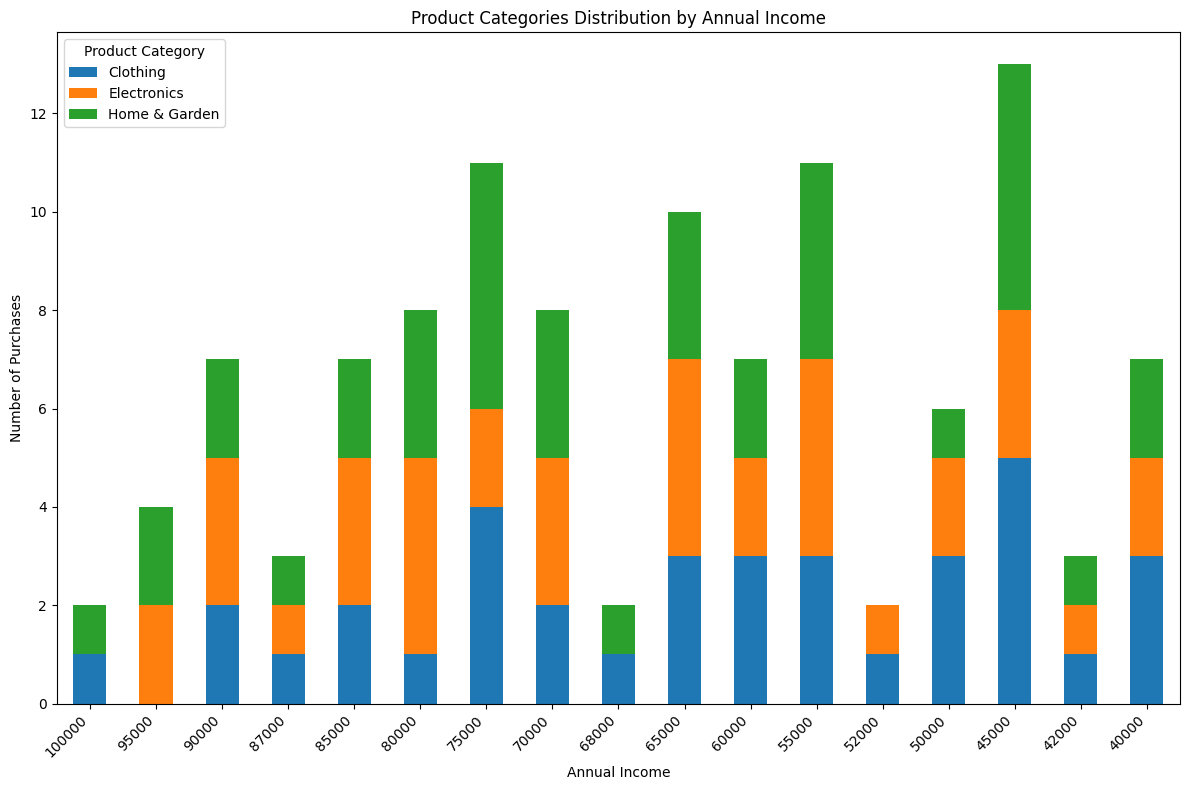

In [32]:
categories = category_pivot.columns
income_brackets = category_pivot.index
category_pivot = category_pivot.sort_index(ascending=False)

fig, ax = plt.subplots(figsize=(12, 8))
category_pivot.plot(kind='bar', stacked=True, ax=ax)

ax.set_title('Product Categories Distribution by Annual Income')
ax.set_xlabel('Annual Income')
ax.set_ylabel('Number of Purchases')
ax.legend(title='Product Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

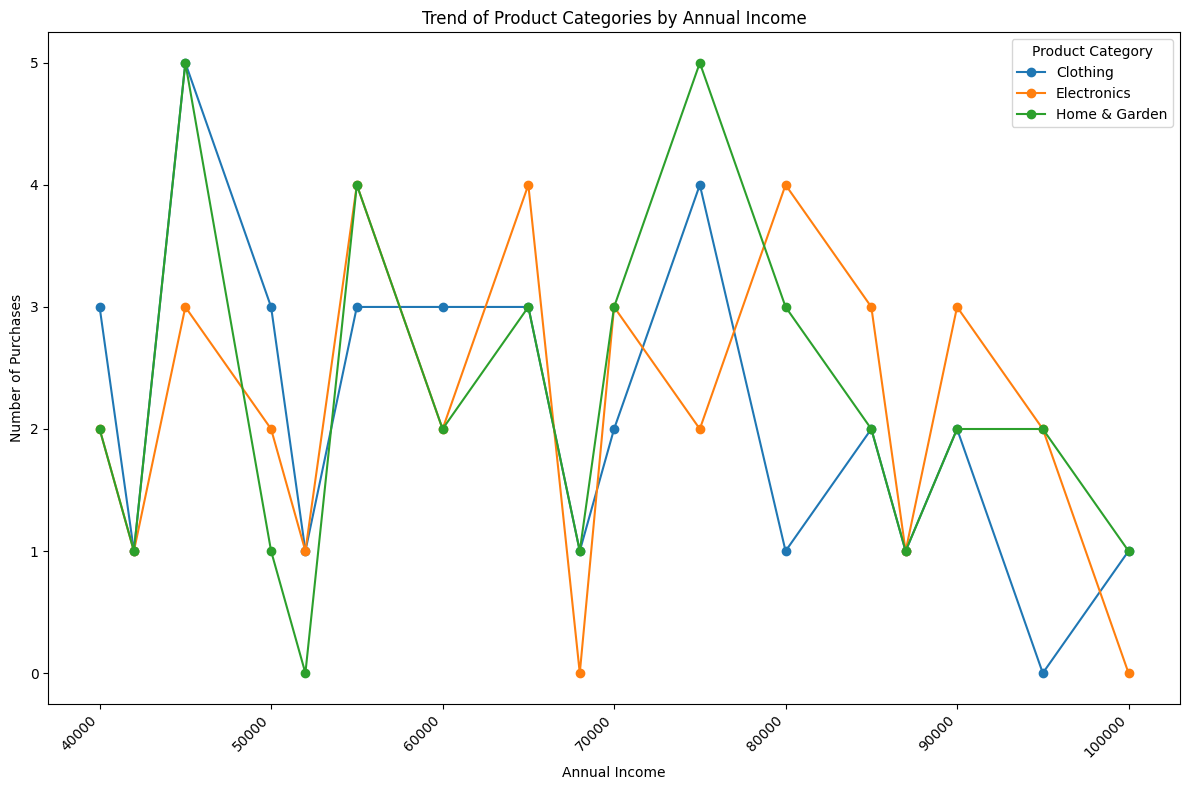

In [33]:
fig, ax = plt.subplots(figsize=(12, 8))

for category in category_pivot.columns:
    ax.plot(category_pivot.index, category_pivot[category], marker='o', label=category)

ax.set_title('Trend of Product Categories by Annual Income')
ax.set_xlabel('Annual Income')
ax.set_ylabel('Number of Purchases')
ax.legend(title='Product Category')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


In [34]:
def convert_to_list(purchase_history):
    try:
        return json.loads(purchase_history.replace("'", '"'))
    except json.JSONDecodeError:
        return []

In [35]:
df['Corrected Purchase History'] = df['Purchase History'].apply(convert_to_list)

In [36]:
def extract_dates(purchase_history):
    if isinstance(purchase_history, list):
        return [purchase.get('Purchase Date') for purchase in purchase_history]
    return []

In [37]:
df['Purchase Dates'] = df['Corrected Purchase History'].apply(extract_dates)

In [38]:
print(df[['Customer ID', 'Purchase Dates']].head())

   Customer ID            Purchase Dates
0         1001        [None, None, None]
1         1001  [2022-05-15, 2022-06-02]
2         1001  [2022-08-15, 2022-07-02]
3         1001                        []
4         1002                        []


In [39]:
df_clean = df[df['Purchase Dates'].apply(lambda x: len(x) > 0)]

In [40]:
print(df_clean[['Customer ID', 'Purchase Dates']].head())

    Customer ID            Purchase Dates
0          1001        [None, None, None]
1          1001  [2022-05-15, 2022-06-02]
2          1001  [2022-08-15, 2022-07-02]
24         1001              [2022-09-15]
38         1001  [2022-08-15, 2022-07-20]


In [41]:
  df_clean['Purchase Dates'] = df_clean['Purchase Dates'].apply(lambda x: [date if date is not None else np.nan for date in x])

/tmp/ipykernel_17/1014577112.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Purchase Dates'] = df_clean['Purchase Dates'].apply(lambda x: [date if date is not None else np.nan for date in x])


In [42]:
print(df_clean[['Customer ID', 'Purchase Dates']].head())

    Customer ID            Purchase Dates
0          1001           [nan, nan, nan]
1          1001  [2022-05-15, 2022-06-02]
2          1001  [2022-08-15, 2022-07-02]
24         1001              [2022-09-15]
38         1001  [2022-08-15, 2022-07-20]


In [43]:
df_clean['Total Purchases'] = df_clean['Purchase Dates'].apply(len)

/tmp/ipykernel_17/3103084014.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Total Purchases'] = df_clean['Purchase Dates'].apply(len)


In [44]:
def calculate_time_intervals(dates):
    dates = [pd.to_datetime(date) for date in dates if pd.notna(date)]
    if len(dates) < 2:
        return []
    return [(dates[i] - dates[i - 1]).days for i in range(1, len(dates))]

In [45]:
df_clean['Purchase Intervals'] = df_clean['Purchase Dates'].apply(calculate_time_intervals)

/tmp/ipykernel_17/3910911658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Purchase Intervals'] = df_clean['Purchase Dates'].apply(calculate_time_intervals)


In [46]:
print(df_clean[['Customer ID', 'Total Purchases', 'Purchase Intervals']].head())

    Customer ID  Total Purchases Purchase Intervals
0          1001                3                 []
1          1001                2               [18]
2          1001                2              [-44]
24         1001                1                 []
38         1001                2              [-26]


In [47]:
negative_intervals_df = df_clean[df_clean['Purchase Intervals'].apply(lambda x: any(i < 0 for i in x))]

In [48]:
print(negative_intervals_df[['Customer ID', 'Purchase Dates', 'Purchase Intervals']])

    Customer ID                        Purchase Dates Purchase Intervals
2          1001              [2022-08-15, 2022-07-02]              [-44]
38         1001              [2022-08-15, 2022-07-20]              [-26]
39         1001              [2022-03-15, 2022-02-01]              [-42]
40         1002              [2022-02-20, 2022-01-12]              [-39]
42         1001              [2022-06-12, 2022-05-08]              [-35]
43         1002              [2022-07-03, 2022-06-17]              [-16]
44         1003              [2022-06-22, 2022-05-15]              [-38]
45         1004              [2022-07-08, 2022-06-24]              [-14]
46         1005              [2022-06-01, 2022-05-18]              [-14]
47         1001  [2022-07-02, 2022-06-15, 2022-05-10]         [-17, -36]
48         1002  [2022-07-08, 2022-06-23, 2022-05-12]         [-15, -42]
49         1003  [2022-07-01, 2022-06-18, 2022-05-09]         [-13, -40]


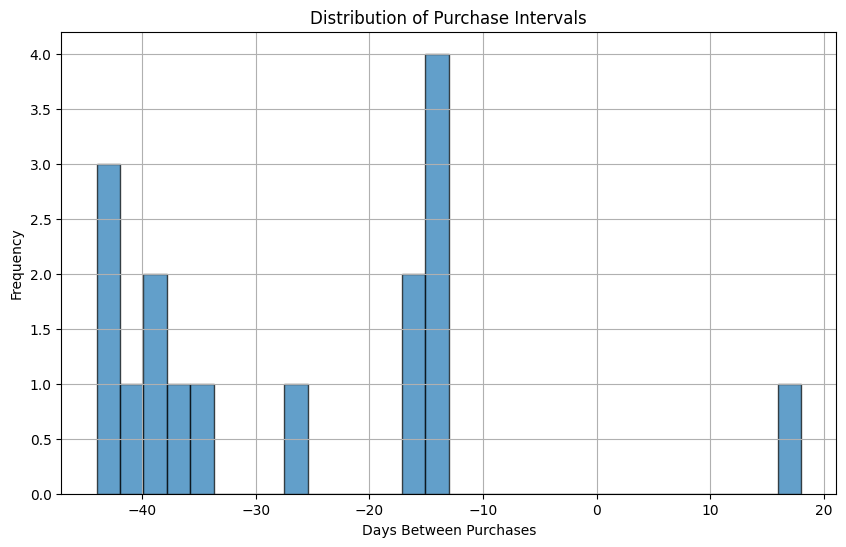

In [49]:
intervals = [interval for sublist in df_clean['Purchase Intervals'] for interval in sublist if pd.notna(interval)]

plt.figure(figsize=(10, 6))
plt.hist(intervals, bins=30, edgecolor='k', alpha=0.7)
plt.title('Distribution of Purchase Intervals')
plt.xlabel('Days Between Purchases')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

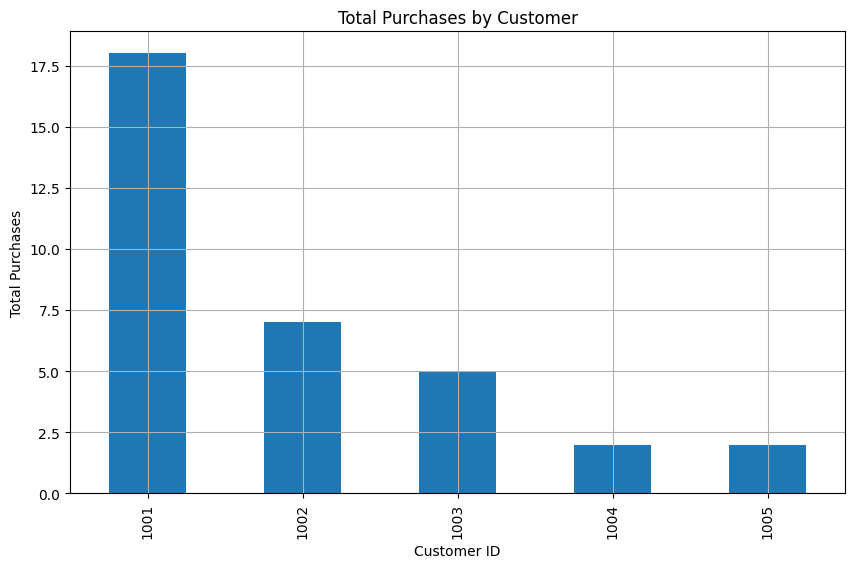

In [50]:
plt.figure(figsize=(10, 6))
df_clean.groupby('Customer ID')['Total Purchases'].sum().plot(kind='bar')
plt.title('Total Purchases by Customer')
plt.xlabel('Customer ID')
plt.ylabel('Total Purchases')
plt.grid(True)
plt.show()

In [51]:
emotion_detector = pipeline("text-classification", model="bhadresh-savani/bert-base-uncased-emotion")

config.json:   0%|          | 0.00/935 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/285 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [52]:
df['emotions'] = df['Cleaned_Reviews'].apply(lambda x: emotion_detector(x))

In [53]:
def extract_emotion(emotion_results):
    return max(emotion_results, key=lambda x: x['score'])['label']

In [54]:
df['emotion_label'] = df['emotions'].apply(extract_emotion)

In [55]:
print(df[['Cleaned_Reviews', 'emotion_label']].head())

                                     Cleaned_Reviews emotion_label
0  great pair of jeans very comfortable rating  s...           joy
1                             great customer service           joy
2  great electronics the sound quality is excelle...           joy
3  great experience buying this product fast deli...           joy
4            good product but could have been better           joy


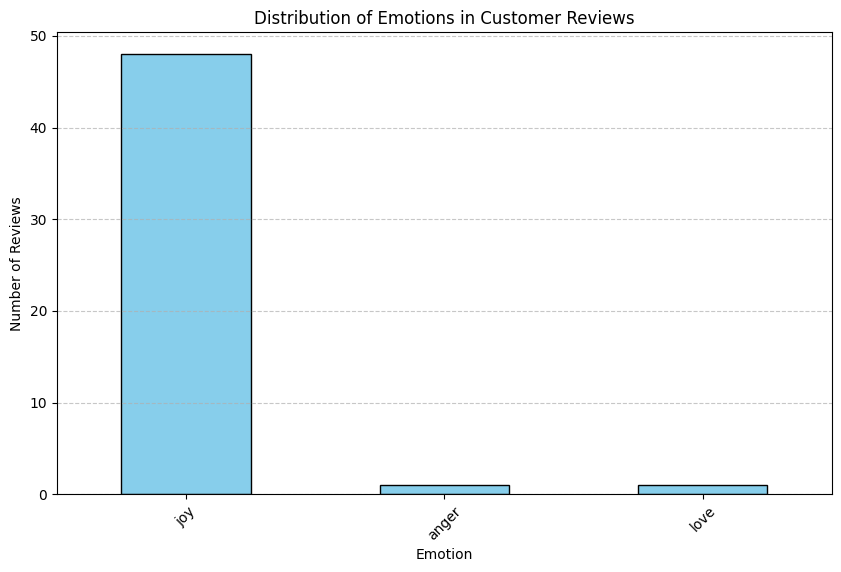

In [56]:
emotion_counts = df['emotion_label'].value_counts()

plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='skyblue', edgecolor='k')
plt.title('Distribution of Emotions in Customer Reviews')
plt.xlabel('Emotion')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


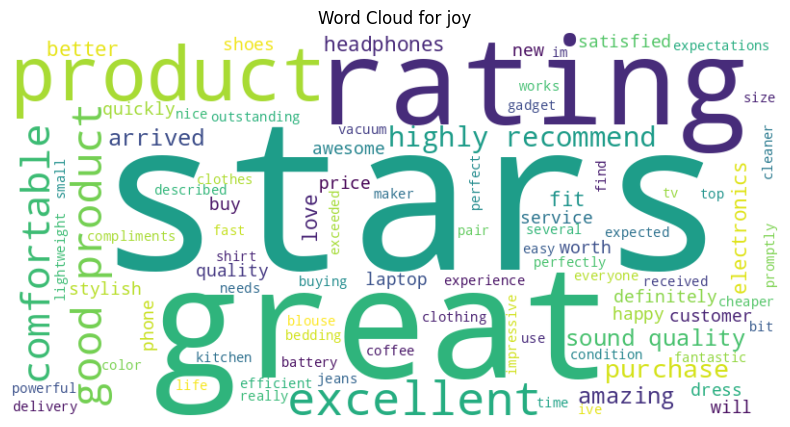

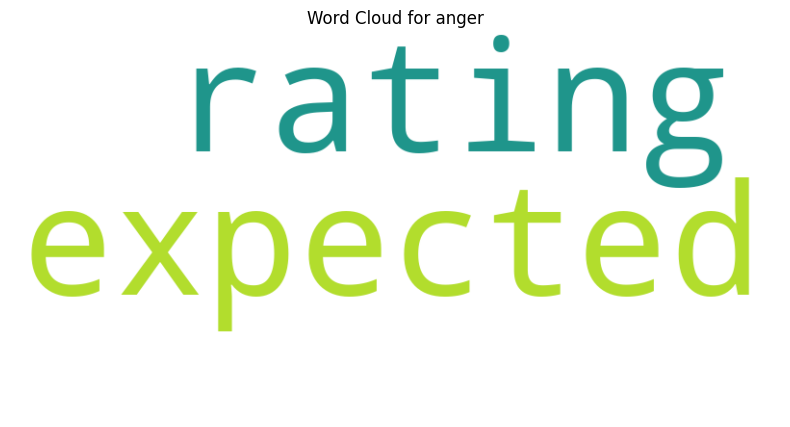

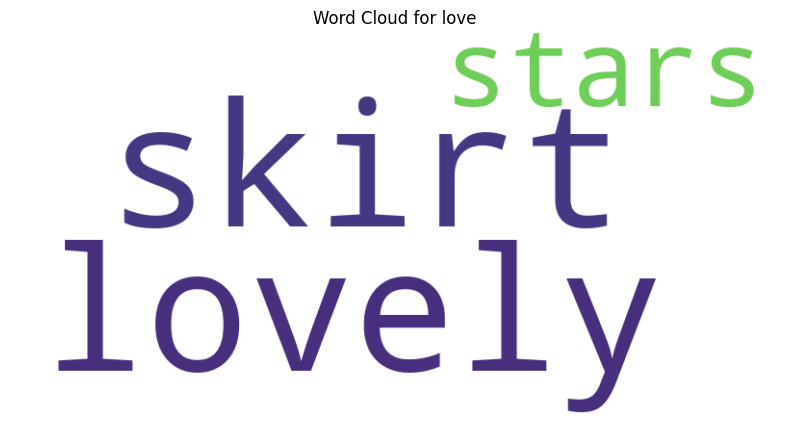

In [57]:
def plot_wordcloud(emotion):
    text = ' '.join(df[df['emotion_label'] == emotion]['Cleaned_Reviews'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {emotion}')
    plt.show()

for emotion in df['emotion_label'].unique():
    plot_wordcloud(emotion)